# Comparative Advantage

Welcome! This agent based model is designed to study comparative advantage. Below are properties of the environment and agents, as well as my notes on various topics that required decisions throughout the program. There are plenty of to-dos and potential upgrades hidden in the notes.

### Environment Properties
1. Agents are randomly assigned discrete positions on a grid.
2. Users decide the size of the grid and the number of agents on the grid.
3. The grid can be partially or completely filled with agents.
5. Agents do not move on the grid.
6. Agents trade with grid neighbors.

### Agent Properties
1. Agents are given production possibilities for two goods. Currently, the production possibility for both goods ranges from 1 to 10 by units of 0.01.
2. A Marginal Rate of Transformation (MRT) for each good is calculated from the production possibilities. This implies a linear production function, $Good_1 = -MRT_1*Good_2 + b$, where $Good_1$ and $Good_2$ are the two goods in the model, $MRT_1$ is the MRT of $Good_1$, and $b$ is the production possibility of $Good_1$ when $Good_2$ is zero.
3. The agent has access to the average price of each good based on transaction history.
4. Agents can set a specialization in one of the goods.
5. Agents can set an offer price and quantity available to sell the specialized good.
6. Agents can set autarky if trade is no trade takes place.
7. Agents keep a transaction history of every seller they visit, even if no trade takes place.

### Agent Scope

### Model Steps

### Notes on Various Topics
#### Utility:
Agent's in this model maximize utility, although utility is never explicitly calculated at any point in the model. Implied through out the program is a utility function $U(X,Y) = X \times Y$. This is possible because the implied utility function and the linear production function make various optimal calculations easy to perform. For example, the optimal amount of specialized good to offer for sale is the same at any price, namely, half the production possibility of the specialized good. If the agent traded more, it would enter decreasing marginal utility. Many of the properties of the model rely on the combination of utility/production functions. Upgrades to this program would generalize from these functions.

#### Production Functions:
$Good_1 = -MRT_1*Good_2 + b$, where $Good_1$ and $Good_2$ are the two goods in the model, $MRT_1$ is the Marginal Rate of Transformation of $Good_1$, $b$ is the production possibility of $Good_1$ when $Good_2$ is zero, and -b/-MRT is the production possibility of $Good_2$ when $Good_1$ is zero. Next iteration would be to generalize this to other potential production functions.

#### Marginal Rate of Transformation (MRT):
MRT of Good 1 is the price of a unit of Good 2. Why? The MRT of Good 1 is the "number of units of Good 1 foregone to produce an additional unit of Good 2." That is, the MRT of Good 1 is the opportunity cost of Good 2, in other words, the "price" of Good 2. One way to capture this would be to name it "own price" or "internal price of Good 2" to make the later comparisons more intuitive.

#### Specialization:
The agent wants to satisfy their goals as completely as possible. Technically, this means striving for the highest utility. The highest potential utility can be found by specializing in production where the agent has a comparative advantage. Why? An agents comparative advantage means they can produce a good relatively cheaper than other agents in the economy. By producing a good more cheaply than someone else, the range of potential price points for benefical exchange is larger than if they produced a more expensive good. As a result, by pursuing their own self-interest, each agent produces goods they are relatively better at producing, increasing total production of both goods in the economy. Since there are many agents, it is not clear to any specific agent where their comparative advantage lies. By looking at average prices, agents can infer their comparative advantage.

#### Price Determination:
#### Trade:


In [1]:
import agentpy as ap
import numpy as np
import pandas as pd

# Visualization of results
import matplotlib.pyplot as plt
import seaborn as sns
import IPython

### Create the Agent

In [181]:
class Person(ap.Agent):
    """ Person Class. Inerits ap.Agent class, AgentPy's default agent class. """

    def setup(self):
        """ setup initiates various agent attributes. """

        # Set a variable 'grid' that gives the agents access to the model's grid.
        self.grid = self.model.grid 

        # Set a random number for the agents to use, the seed is set as a parameter.
        self.random = self.model.random

        # Initialize the goods attribute dictionary.
        self.goods = {
            self.p.good_1: {
                'production': round(self.random.choice(np.arange(1, 10, 0.01)), 2)
            },
            self.p.good_2: {
                'production': round(self.random.choice(np.arange(1, 10, 0.01)), 2)
            } 
        }

        # Set the marginal rate of transformation (MRT) for each good.
        self.goods[self.p.good_1]['mrt'] = round(self.goods[self.p.good_1]['production'] / self.goods[self.p.good_2]['production'], 2)
        self.goods[self.p.good_2]['mrt'] = round(self.goods[self.p.good_2]['production'] / self.goods[self.p.good_1]['production'], 2)

        # Initialize production status.
        self.in_autarky = None
        self.specialization = None
        self.non_specialization = None

        # Initialize offer attributes and transaction history.
        self.offer_quantity = None
        self.offer_price = None
        self.transactions = pd.DataFrame(columns=['time', 'seller_id', 'buyer_id', 'quantity', 'product', 'price'])

    def impld_trans(self, row):
        """ Create an implied transaction for every actual transaction. """
        if row['product'] == self.p.good_1:
            row['product'] = self.p.good_2
        elif row['product'] == self.p.good_2:
            row['product'] = self.p.good_1

        row['quantity'] = round(row['price']*row['quantity'], 2)
        row['price'] = round(1 / row['price'], 2)

        return row

    def wt_avg(self, col):
        """ Return an average price weighted by the quantity traded. """
        values = col['price']
        weights = col['quantity']

        return np.average(values, weights=weights)

    def updt_avg_prices(self):
        """ Update the average price of each good. """

        # Without a transaction history, then average prices are undetermined.
        if self.transactions.loc[self.transactions['quantity'] > 0].empty == True:
            self.goods[self.p.good_1]['average_price'] = None
            self.goods[self.p.good_2]['average_price'] = None
            return None

        # Create implied transactions.
        impld = self.transactions.loc[self.transactions['quantity'] > 0].apply(self.impld_trans, axis=1)
        full = pd.concat([self.transactions, impld], ignore_index=True)

        # Calculate the average price of each product.
        avg_prices = (
            full
            .loc[full['quantity'] > 0]
            .groupby(by=['product'])
            .apply(self.wt_avg)
        )

        # Set average prices for each good.
        for good in self.goods.keys():
            self.goods[good]['average_price'] = round(avg_prices[good], 2)

    def updt_spec(self):
        """
        updt_spec determines the agent's comparative advantage and specialization.

        Setting Specialization:
        If an average price could not be determined: the agent has not traded with any other agents and
        the agent is a new market entrant. As a new entrant, the agent will choose their specialzation randomly.
        Although: If the new entrant uses a % mark-up, then random selection is fine since utility is identical.
        If it uses a nominal markup, then the % are different and an "optimal" choice is not random, but good the
        the agent produces in the highest quantity. Therefore, *how* the agent sets a price without a market
        signal can change the optimal specialization.

        If an average price could be determined: If the agent's MRT of good 1 (good 2)--opportunity cost of
        good 2 (good 1)--is below the average price of good 2 (good 1) and the MRT of good 2 (good 1)--
        opportunity cost of good 1 (good 2)--is above the average price of good 1, then based on average prices
        the agent has a comparative advantage in the production of good 2. That is, the agent produces good 2
        at a lower price than the average agent.

        If the agent's MRT of both goods are below the average price of both goods, then agent appears to have
        a comparative advantage in both goods. In this case, the agent should choose to specialize in the good
        with the greatest comparative advantage, as measured by the relative size of the agents MRT and the
        average price.

        Lastly, if the agent's MRT of both goods is at least the average price of both goods, then the agent
        appreas to have not a comparative advantage in the production of either good. This should virutally
        never occur. If this is occurring regularly, I think it's because the methodology for calculating
        average price is flawed. When it happens I have opted to print a statement and randomly select a
        specialization to keep the simulation going.
        """
        if (self.goods[self.p.good_1]['average_price'] == None and
            self.goods[self.p.good_2]['average_price'] == None):
            self.specialization = self.random.choice(list(self.goods.keys()))
        elif (self.goods[self.p.good_1]['mrt'] < self.goods[self.p.good_2]['average_price'] and
              self.goods[self.p.good_2]['mrt'] >= self.goods[self.p.good_1]['average_price']):
            self.specialization = self.p.good_2
        elif (self.goods[self.p.good_1]['mrt'] >= self.goods[self.p.good_2]['average_price'] and
              self.goods[self.p.good_2]['mrt'] < self.goods[self.p.good_1]['average_price']):
            self.specialization = self.p.good_1
        elif (self.goods[self.p.good_1]['mrt'] < self.goods[self.p.good_2]['average_price'] and
              self.goods[self.p.good_2]['mrt'] < self.goods[self.p.good_1]['average_price']):
            rel_pg2 = self.goods[self.p.good_1]['mrt'] / self.goods[self.p.good_2]['average_price']
            rel_pg1 = self.goods[self.p.good_2]['mrt'] / self.goods[self.p.good_1]['average_price']

            if rel_pg1 < rel_pg2:
                self.specialization = self.p.good_1
            elif rel_pg1 > rel_pg2:
                self.specialization = self.p.good_2
            else:
                self.specialization = self.random.choice(list(self.goods.keys()))
        else:
            print(f"{self.id}: No comparative advantage.")
            self.specialization = self.random.choice(list(self.goods.keys()))

        if self.specialization != None:
            specs = list(self.goods.keys())
            specs.remove(self.specialization)
            self.non_specialization = specs[0]
        else:
            self.non_specialization = None

    def updt_offer(self):
        """
        Set three attributes: the amount produced of the specialized good, the maximum
        amount of the specialized good the agent is willing to sell, and the offer price
        of the specialized good.

        Specialized Production:
        In specializing, the agent will produce the production possibility of the specialized
        good and none of the non-specialized good. Why? The production function used is linear
        and the corner solution is implied a linear production function Good_1 = -MRS * Good_2 + B.

        Trading:
        If specialization and trade do occur, then the maximum the agent is willing to sell
        is always equal to half of their production possibility of the specialized good. Why?
        That is what the utility function U = X*Y implies and it is unaffected by price.

        By using a specific utility funciton and production function, the optimal amounts
        produced and offered are easy to calculate, as I have done. If you change the utility
        function or the production function and you change the point where specialization and
        trade will occur. Being able to use general production and utility functions is
        preferred, but beyond the task of this program.

        Price Determination:
        Genearlly, an agent is willing to sell the specialized good at any price greater than
        the MRT of the specialized good. In other words, if the amount of the specialized good
        given up to obtain an additional unit of the non-specialized good is lower on the market
        then they will choose to purchase the non-specialized good intead of producing it.
    
        Overall, the minimum price is the MRT of the specialized good. The maximum price is the
        MRT of the non-specialized good of the seller. The actual price must be some where between
        these two prices.

        As described, from the agents point of view, the minimum price then is always known since
        the agent knows their own MRT. The maximum price is not well known to the agent. There are
        many potential sellers with different MRTs of their own.

        If an average price can be determined, then the price is set to the average price. If an
        average price is undetermined, then the agent sets their price such that it's high
        enough to make trading worthwhile. Currently, I use MRT * 1.10 instead of + 0.01, the latter
        being the absolute minimum to make trading worthwhile.
        """
 
        # Set production of specialized and non-specialized goods.
        self.goods[self.specialization]['quantity'] = self.goods[self.specialization]['production']
        self.goods[self.non_specialization]['quantity'] = 0

        # Set the maximum quantity of specialized good for sale.
        self.offer_quantity = round(self.goods[self.specialization]['production'] / 2, 2)

        # Set the price to sell the specialized good.
        if self.goods[self.specialization]['average_price'] == None:
            self.offer_price = round(self.goods[self.non_specialization]['mrt'] * 1.10, 2)
        else:
            self.offer_price = self.goods[self.specialization]['average_price']

    def find_sellers(self):
        """
        find_seller randomly selects a neighbor with goods in stock and does not sell
        the same good the buyer specialized in producing. If the selected seller does
        not have goods in stock, then their "store" is "closed" in that no buyers can
        view their list prices.

        Return ap.Agent type or None type.
        """

        # Compile neighbors that are open for business and selling the good
        # the agent wants to buy.
        neighbors = []

        for n in self.grid.neighbors(self, distance=self.p.region):
            if n.offer_quantity > 0 and n.specialization != self.specialization:
                neighbors.append(n)

        # If no sellers are found, return none, otherwise randomly select
        # sellers based on the number of "stores" agent's are allowed to visit.
        if len(neighbors) == 0:
            return neighbors
        elif len(neighbors) > 0 and len(neighbors) < self.p.visits:
            return np.random.choice(neighbors, size=len(neighbors), replace=False)
        elif len(neighbors) >= self.p.visits:
            return np.random.choice(neighbors, size=self.p.visits, replace=False)

    def trade(self):
        """ Trade with sellers.
        
        Trading:
        If the randomly selected neighbor: (1) does not specialize in the same good
        as the buyer and (2) their price is below the buyers MRT of the specialized good,
        then trading will occur. Otherwise, record the interaction, but do not execute
        any trades.

        Both the buyer and seller are limited by their respective available quantities.
        If the seller's quantity is less than the amount the buyer could purchase at the
        seller's listed price, then the buyer will purchase the sellers entire quantity
        for the amount of the sellers list price multiplied by the sellers available
        quantity. (R = P * Q).

        If the seller's quantity available is greater than the amount the buyer can purcahse,
        then the buyer purchases an amount equal to the sellers quantity divided by the seller's
        list price. (Q = R / P).
        """

        # Find a seller.
        sellers = self.find_sellers()

        # If a seller was not found, then trading does not occur.
        if len(sellers) == 0:
            return None

        # Set buy and sell quantities based on availability and price.
        # Continue to visit sellers until there is no quantity left to trade.
        for seller in sellers:
            if self.offer_quantity > 0:
                if seller.offer_price < self.goods[self.specialization]['mrt']:
                    if seller.offer_quantity < round(self.offer_quantity * (1 / seller.offer_price), 2):
                        buy = round(seller.offer_quantity, 2)
                        sell = round(seller.offer_quantity * seller.offer_price, 2)
                    else:
                        buy = round(self.offer_quantity * (1 / seller.offer_price), 2)
                        sell = round(self.offer_quantity, 2)
                else:
                    buy = 0
                    sell = 0

                # Create a transaction history.
                receipt = pd.DataFrame(
                    data = [
                        [self.model.t, seller.id, self.id, buy, seller.specialization, seller.offer_price]
                    ],
                    columns = self.transactions.columns
                )

                # Update the buyer and seller details and add the receipt to their transaction log.
                # Buyer:
                self.offer_quantity = round(self.offer_quantity - sell, 2)
                self.goods[self.specialization]['quantity'] = round(self.goods[self.specialization]['quantity'] - sell, 2)
                self.goods[self.non_specialization]['quantity'] = round(self.goods[self.non_specialization]['quantity'] + buy, 2)
                self.transactions = self.transactions.append(receipt, ignore_index=True)

                # Seller:        
                seller.offer_quantity = seller.offer_quantity - buy
                seller.goods[seller.specialization]['quantity'] = seller.goods[seller.specialization]['quantity'] - buy
                seller.goods[seller.non_specialization]['quantity'] = seller.goods[seller.non_specialization]['quantity'] + sell
                seller.transactions = seller.transactions.append(receipt, ignore_index=True)
            else:
                break

    def set_autarky(self):
        """ Determine if the agent produces in autarky.

        With a uility function U=(X*Y), autarky production is always
        half the production possibilities for each good.
        """

        # Find out if a trade occured.
        trading = self.transactions.loc[
            (self.transactions['time'] == self.model.t) &
            (self.transactions['quantity'] > 0)
        ]

        # If trading did not occur, then the agent will produce in autarky.
        if trading.empty == True:
            self.in_autarky = True

            for good in self.goods.keys():
                self.goods[good]['quantity'] = round(self.goods[good]['production'] / 2)
        else:
            self.in_autarky = False

### The Model

In [182]:
class ComparativeAdvantage(ap.Model):

    def setup(self):

        # Create grid, called grid. ap.Grid() is n-dimensional spatial topology with discrete positions.
        self.grid = ap.Grid(self, (self.p.size, self.p.size), track_empty=True)

        # Create agents by creating an AgentList. There is only one type of agent in this model: Person.
        self.agents = ap.AgentList(self, self.p.population, Person)

        # Add agents to grid.
        self.grid.add_agents(self.agents, random=True, empty=True)

    def update(self):

        # Update the agent's average price of transactions.
        self.agents.updt_avg_prices()

        # Update the agent's specialization.
        self.agents.updt_spec()

        # Update the agent's offer to sell the good the agent specialized in producing.
        self.agents.updt_offer()

    def step(self):
        # Find agents to trade with.
        self.agents.trade()

        # Set autarky.
        self.agents.set_autarky()

        # Record the percent of agents in autarky.
        pct_autarky = np.sum(list(self.agents.in_autarky)) / self.p.population
        self.record('pct_autarky', pct_autarky)

    def end(self):
        pass

### Run the Model

In [207]:
parameters = {
    'steps': 50,
    'seed': 92,
    'size': 10,
    'population': 100,
    'good_1': 'bread',
    'good_2':'butter',
    'region': 5,
    'visits': 8
 }

model = ComparativeAdvantage(parameters)
results = model.run()

Completed: 50 steps
Run time: 0:00:46.284950
Simulation finished


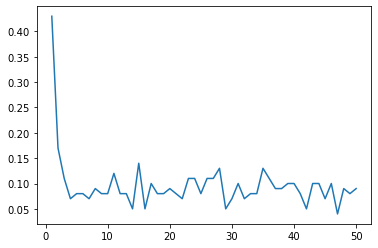

In [208]:
plt.plot(results.variables.ComparativeAdvantage.pct_autarky)

Interactive Visualization

In [52]:
parameters = {
    'steps': 5,
    'seed': 92,
    'size': 10,
    'population': 100,
    'good_1': 'bread',
    'good_2':'butter',
    'demo': False
 }

In [55]:
def animation_plot(model, ax):
    autarky_grid = model.grid.attr_grid('in_autarky')
    avg_pr_grid = model.grid.attr_grid('')
    ap.gridplot(autarky_grid, ax=ax[0])
    ap.gridplot(autarky_grid, ax=ax[1])

    # ax.set_title(f"Segregation model \n Time-step: {model.t}, "
    #              f"Segregation: {model.get_segregation()}")

fig, ax = plt.subplots(nrows=1, ncols=2)
model = ComparativeAdvantage(parameters)
animation = ap.animate(model, fig, ax, animation_plot)
IPython.display.HTML(animation.to_jshtml())

/Users/barbieri/opt/anaconda3/lib/python3.8/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/Users/barbieri/opt/anaconda3/lib/python3.8/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/Users/barbieri/opt/anaconda3/lib/python3.8/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
